# Task description
Use the train data which contains 2017 and part of 2018 average traffic speed of a major road in Hong Kong and their corresponding timestamp to predict speed in 2018. The total work includes data integration, feature engineering, model training and final prediction. Task is roughly categorized as regression, so I tried a collection of regressors like RandomForestRegressor or XGBoostRegressor and selected the best one. For model construction, I mainly tried two ways. One is built on randomly spliting trainset and testset from train.csv and use the model to predict test.csv. Another is built on data in 2017, evaluate the model on 2018 in train.csv, and use the final model trained to predict test.csv. Performance evaluation mainly includes mse. All of the decision is based on entensive comparison. My exploration of the data is reported as follows.

**Outline**
* Take a brief look at data
* Extract useful features from train data
* Merge weather data from other sources
* Plot analysis
* Prepare the data for machine learning
* Train models
* Fine tune models
* Model evaluation
* Prediction on test data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather/wr.csv
/kaggle/input/msbd5001-fall2020/train.csv
/kaggle/input/msbd5001-fall2020/sampleSubmission.csv
/kaggle/input/msbd5001-fall2020/test.csv


In [2]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Take a brief look at data

In [3]:
# Importing dataset from csv to data frame
train=pd.read_csv('../input/msbd5001-fall2020/train.csv')
test=pd.read_csv('../input/msbd5001-fall2020/test.csv')
train.head(10)

,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653
5,5,1/1/2017 5:00,46.797766
6,6,1/1/2017 6:00,44.404925
7,7,1/1/2017 7:00,45.255897
8,8,1/1/2017 8:00,45.680859
9,9,1/1/2017 9:00,48.435676


In [4]:
print(train.shape)
print(test.shape)

(14006, 3)
(3504, 2)


In [5]:
train.dtypes

id         int64
date      object
speed    float64
dtype: object

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [7]:
train.isna().value_counts()

id     date   speed
False  False  False    14006
dtype: int64

No Na in data.

In [8]:
train.drop('id',axis=1).describe()

,speed
count,14006.000000
mean,32.779118
std,13.573813
min,2.573417
25%,19.301089
50%,36.580595
75%,45.877665
max,53.161286


Speed is around (32.78 ± 13.57).

In [9]:
print("max date : "+train.date.max())
print("min date : "+train.date.min())

max date : 9/9/2018 8:00
min date : 1/1/2017 0:00


In [10]:
trainset=train.copy()
trainset.drop('id',axis=1,inplace=True)

# Extract useful features from train data

In [11]:
# Split datetime
trainset['year']=trainset['date'].apply(lambda y:int(y.split()[0].split('/')[2]))
trainset['month']=trainset['date'].apply(lambda m:int(m.split()[0].split('/')[1]))
trainset['day']=trainset['date'].apply(lambda d:int(d.split()[0].split('/')[0]))
trainset['time']=trainset['date'].apply(lambda t:int(t.split()[1].split(':')[0]))
trainset['datetime']=trainset['date'].apply(lambda x:
            datetime.datetime(  int(x.split()[0].split('/')[2]),
                int(x.split()[0].split('/')[1]),
                int(x.split()[0].split('/')[0]),
                int(x.split()[1].split(':')[0])  )
                                           )

In [12]:
# Whether a day is weekend or not
trainset['IsWeekend']=trainset['datetime'].apply(lambda x:0 if x.weekday() in [0,1,2,3,4] else 1)

In [13]:
# Whether a day is Hong Kong General Holidays
trainset['IsHoliday']=trainset['datetime'].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
           '2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04',
           '2017-04-14','2017-04-15','2017-04-17','2017-05-01','2017-05-03',
           '2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28',
           '2017-12-25','2017-12-26',
           '2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-03-30',
           '2018-03-31','2018-04-02','2018-04-05','2018-05-01','2018-05-22',
           '2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17',
           '2018-12-25','2018-12-26'
           ])
           or(x.weekday() in[6]) else 0)

Hong Kong General Holiday information is taken from https://www.gov.hk/en/about/abouthk/holiday/2018.htm

In [14]:
# Categorizing hours to different time periods like morning, afternoon, etc.
def hour_modify(x):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [0,1,2,3]
    if x in Early_Morning:
        return 'Early_Morning'
    elif x in Morning:
        return 'Morning'
    elif x in Afternoon:
        return 'Afternoon'
    elif x in Evening:
        return 'Evening'
    elif x in Night:
        return 'Night'
    else:
        return 'Late_Night'
    
trainset['hour_modify']=trainset['time'].apply(hour_modify)
trainset.head()

,date,speed,year,month,day,time,datetime,IsWeekend,IsHoliday,hour_modify
0,1/1/2017 0:00,43.002930,2017,1,1,0,2017-01-01 00:00:00,1,1,Late_Night
1,1/1/2017 1:00,46.118696,2017,1,1,1,2017-01-01 01:00:00,1,1,Late_Night
2,1/1/2017 2:00,44.294158,2017,1,1,2,2017-01-01 02:00:00,1,1,Late_Night
3,1/1/2017 3:00,41.067468,2017,1,1,3,2017-01-01 03:00:00,1,1,Late_Night
4,1/1/2017 4:00,46.448653,2017,1,1,4,2017-01-01 04:00:00,1,1,Early_Morning


# Merge weather data from other sources

As is known to all, the traffic speed is largely related to weather like visibility, amount of rainfall. And quite often an accident is likely to occur in a foggy or snowy weather, which would also affect speed in traffic. Broadly, I collected daily weather data from HONG KONG OBSERVATORY. For collection, I crawlled the data from their website as follows.

In [15]:
def crawl_weather():
    YEAR=['2017','2018']
    MONTH=['01','02','03','04','05','06','07','08','09','10','11','12']
    URL='https://www.hko.gov.hk/en/wxinfo/pastwx/metob'
    wr=pd.DataFrame({},columns=['year','month','day','MPressure(hPa)',
                  'MaxTemp(℃)','MinTemp(℃)','MCloud(%)',
                  'TRainfall(mm)','#hRedVisi(h)','WindDirect(degrees)',
                  'MWindSpeed(km/h)'],
              index=range(365*2))

    cnt=0
    for yr in YEAR:
        for mon in MONTH:
            url=URL+yr+mon+'.htm'
            ymhtml=requests.get(url)
            soup=BeautifulSoup(ymhtml.text,'lxml')
            tbls=soup.find_all('table')
            tbl0=tbls[0].find_all('tr')
            tbl1=tbls[1].find_all('tr')

            for tr1,tr2 in zip(tbl0[2:-3],tbl1[1:-3]):
                wr.iloc[cnt,0]=yr
                wr.iloc[cnt,1]=mon
                tds1=tr1.find_all('td')
                tds2=tr2.find_all('td')

                wr.iloc[cnt,2]=tds1[0].contents[0]
                wr.iloc[cnt,3]=tds1[1].contents[0]
                wr.iloc[cnt,4]=tds1[2].contents[0]
                wr.iloc[cnt,5]=tds1[4].contents[0]
                wr.iloc[cnt,6]=tds1[7].contents[0]
                wr.iloc[cnt,7]=tds1[8].contents[0]

                wr.iloc[cnt,8]=tds2[1].contents[0]
                wr.iloc[cnt,9]=tds2[5].contents[0]
                wr.iloc[cnt,10]=tds2[6].contents[0]
                cnt+=1
                
    wr.to_csv('../input/weather/wr.csv')


For connection reason on kaggle, I can only run the crawl_weather() above locally and upload csv file.

In [16]:
weather=pd.read_csv("../input/weather/wr.csv")
weather.drop("Unnamed: 0",axis=1,inplace=True)
weather['year'].apply(lambda t:int(t))
weather['month'].apply(lambda t:int(t))
weather['day'].apply(lambda t:int(t))
weather.head()

,year,month,day,MPressure(hPa),MaxTemp(℃),MinTemp(℃),MCloud(%),TRainfall(mm),#hRedVisi(h),WindDirect(degrees),MWindSpeed(km/h)
0,2017,1,1,1021.7,20.8,18.4,72,-,0,60,34.2
1,2017,1,2,1020.2,23.3,18.4,28,-,0,70,17.7
2,2017,1,3,1019.8,21.3,18.9,56,-,5,70,26.1
3,2017,1,4,1018.7,21.7,18.7,51,-,0,70,27.7
4,2017,1,5,1016.9,23.4,18.9,61,-,0,40,14.3


I extracted these necessary information in weather table. Column information is listed as follows:
* year: Year of weather
* month: Month of weather
* day: Day of weather
* MPressure(hPa): Mean Pressure in hPa
* MaxTemp(℃): Maximum air temperature in deg. C of a day
* MinTemp(℃): Minimum air temperature in deg. C of a day
* MCloud(%): Mean amount of cloud (%) of a day
* TRainfall(mm): Total rainfall (mm) of a day
* #hRedVisi(h): Number of hours of reduced visibility# (hours)
* WindDirect(degrees): Prevailing wind direction (degrees)
* MWindSpeed(km/h): Mean wind speed (km/h)

In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 730 non-null    int64  
 1   month                730 non-null    int64  
 2   day                  730 non-null    int64  
 3   MPressure(hPa)       730 non-null    float64
 4   MaxTemp(℃)           730 non-null    float64
 5   MinTemp(℃)           730 non-null    float64
 6   MCloud(%)            730 non-null    int64  
 7   TRainfall(mm)        730 non-null    object 
 8   #hRedVisi(h)         730 non-null    int64  
 9   WindDirect(degrees)  730 non-null    int64  
 10  MWindSpeed(km/h)     730 non-null    float64
dtypes: float64(4), int64(6), object(1)
memory usage: 62.9+ KB


In [18]:
weather.drop(['year','month','day'],axis=1).describe()

,MPressure(hPa),MaxTemp(℃),MinTemp(℃),MCloud(%),#hRedVisi(h),WindDirect(degrees),MWindSpeed(km/h)
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,1012.883562,26.564110,22.012877,70.315068,1.032877,140.671233,23.796849
std,6.504514,5.354513,5.088792,22.101572,2.924569,110.679229,10.542179
min,990.900000,10.600000,6.800000,4.000000,0.000000,10.000000,4.000000
25%,1008.400000,22.700000,17.900000,59.000000,0.000000,60.000000,15.900000
50%,1013.400000,27.400000,23.000000,79.000000,0.000000,80.000000,23.600000
75%,1017.500000,31.100000,26.400000,88.000000,0.000000,220.000000,30.650000
max,1028.200000,36.600000,29.800000,100.000000,21.000000,360.000000,101.300000


In [19]:
weather['TRainfall(mm)'].value_counts()

-        297
Trace    153
0.2       17
0.1       15
0.3       13
        ... 
11.1       1
1.7        1
39.6       1
7.1        1
11.6       1
Name: TRainfall(mm), Length: 174, dtype: int64

In [20]:
# Clean the Na 
weather['TRainfall(mm)_num']=weather['TRainfall(mm)'].apply(lambda x:0 if x in ['-','Trace'] else x)

Although cloud coverage, rainfall, and visibility vary from time to time in a day, consequently having an influence on speed, we assume they do not change too much within a day's range. Then we can merge weather table onto train table.

In [21]:
trainset['common']=trainset['datetime'].apply(lambda x:x.date())
def addup(x):
    return datetime.datetime(x[0],x[1],x[2]).date()
weather['common']=weather.apply(addup,axis=1)

data=pd.merge(trainset[['datetime','year','month','day','time','speed','IsWeekend','IsHoliday','hour_modify','common']],
              weather[['MaxTemp(℃)','MinTemp(℃)','MCloud(%)','TRainfall(mm)_num','#hRedVisi(h)','WindDirect(degrees)','MWindSpeed(km/h)','common']],on='common',how='left')\

data.head()

,datetime,year,month,day,time,speed,IsWeekend,IsHoliday,hour_modify,common,MaxTemp(℃),MinTemp(℃),MCloud(%),TRainfall(mm)_num,#hRedVisi(h),WindDirect(degrees),MWindSpeed(km/h)
0,2017-01-01 00:00:00,2017,1,1,0,43.002930,1,1,Late_Night,2017-01-01,20.8,18.4,72,0,0,60,34.2
1,2017-01-01 01:00:00,2017,1,1,1,46.118696,1,1,Late_Night,2017-01-01,20.8,18.4,72,0,0,60,34.2
2,2017-01-01 02:00:00,2017,1,1,2,44.294158,1,1,Late_Night,2017-01-01,20.8,18.4,72,0,0,60,34.2
3,2017-01-01 03:00:00,2017,1,1,3,41.067468,1,1,Late_Night,2017-01-01,20.8,18.4,72,0,0,60,34.2
4,2017-01-01 04:00:00,2017,1,1,4,46.448653,1,1,Early_Morning,2017-01-01,20.8,18.4,72,0,0,60,34.2


# Plot analysis

**Univariate analysis**

In [22]:
data_taken_for_train=data.drop(['datetime','common'],axis=1)
data_taken_for_train.head()

,year,month,day,time,speed,IsWeekend,IsHoliday,hour_modify,MaxTemp(℃),MinTemp(℃),MCloud(%),TRainfall(mm)_num,#hRedVisi(h),WindDirect(degrees),MWindSpeed(km/h)
0,2017,1,1,0,43.002930,1,1,Late_Night,20.8,18.4,72,0,0,60,34.2
1,2017,1,1,1,46.118696,1,1,Late_Night,20.8,18.4,72,0,0,60,34.2
2,2017,1,1,2,44.294158,1,1,Late_Night,20.8,18.4,72,0,0,60,34.2
3,2017,1,1,3,41.067468,1,1,Late_Night,20.8,18.4,72,0,0,60,34.2
4,2017,1,1,4,46.448653,1,1,Early_Morning,20.8,18.4,72,0,0,60,34.2


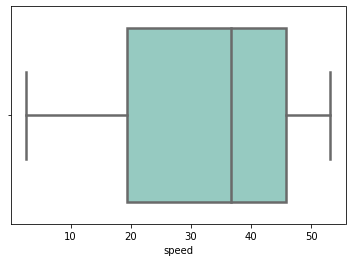

In [23]:
plt.figure(figsize=(6,4))
sns.boxplot('speed',data=data_taken_for_train,orient='h',palette="Set3",linewidth=2.5)
plt.show()

No significant outlier. No need to eliminate data.

Traffic speed across months.

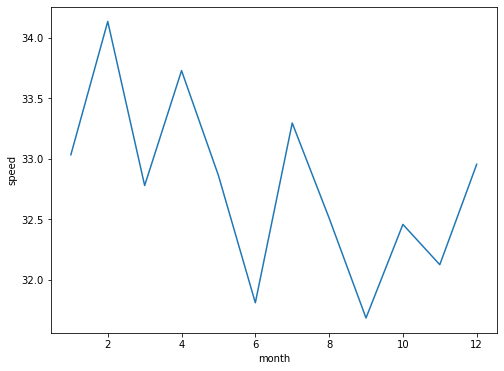

In [24]:
tmp_data=data_taken_for_train.groupby('month').aggregate({'speed':'mean'})
plt.figure(figsize=(8,6))
sns.lineplot(x=tmp_data.index,y=tmp_data.speed,data=tmp_data,palette="Set2")
plt.show()

Count on different hour stage.

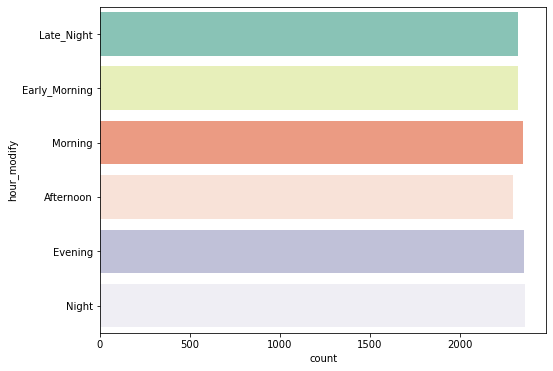

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(y='hour_modify',data=data_taken_for_train,palette=["#7fcdbb","#edf8b1","#fc9272","#fee0d2","#bcbddc","#efedf5"])
plt.show()

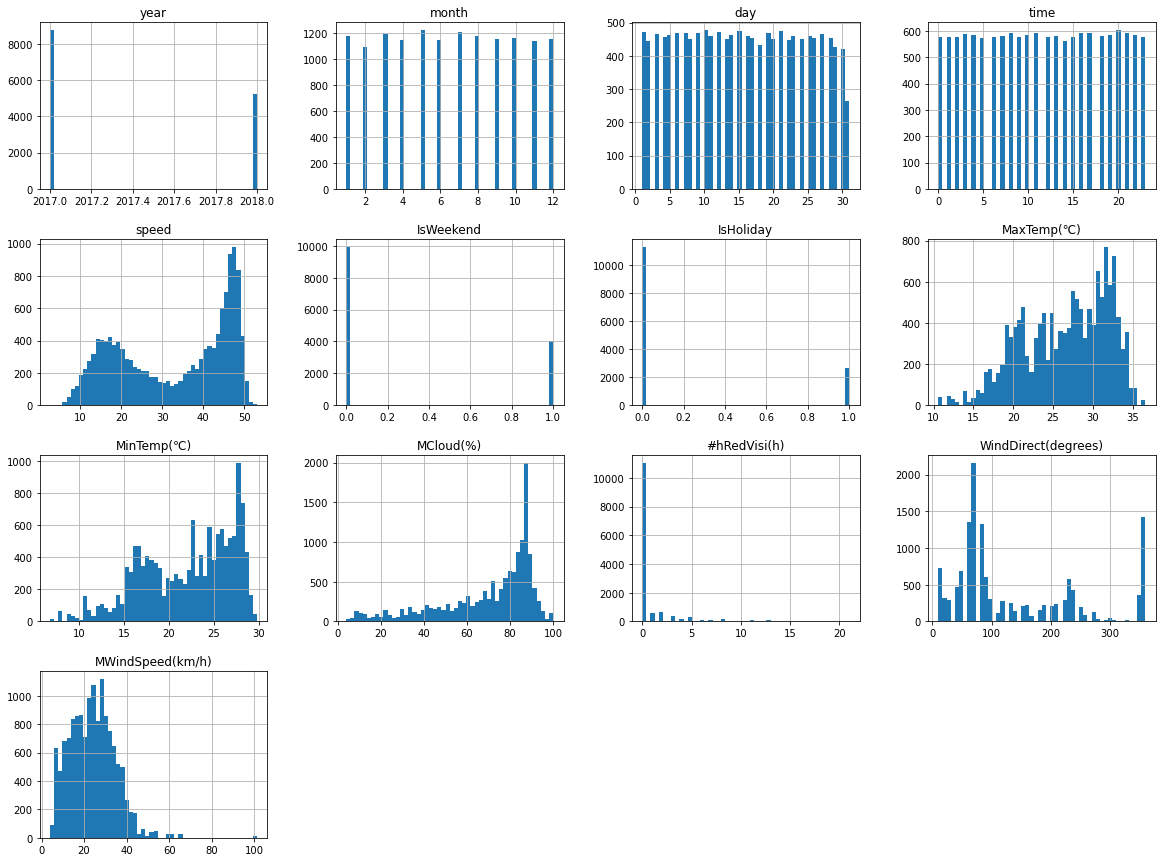

In [26]:
data_taken_for_train.hist(bins=50,figsize=(20,15))
plt.show()

Speed is high in rush hour, and speed in the afternoon is higher than morning. <p>
There seems some positive correlation between max/ min temperature, mean cloud coverage and speed. <p>
And negative correlation between wind mean wind speed and speed. <p>
Some left skewed in number of hours of reduced visibility# (hours) and some right skewed in mean cloud coverage (%). <p>
Categorical variables are almost balanced.

**Bivariate analysis** 

Plotting relationship between speed, MaxTemp, MinTemp, MCloud, #hRedVisi(h), WindDirect, MWindSpeed.

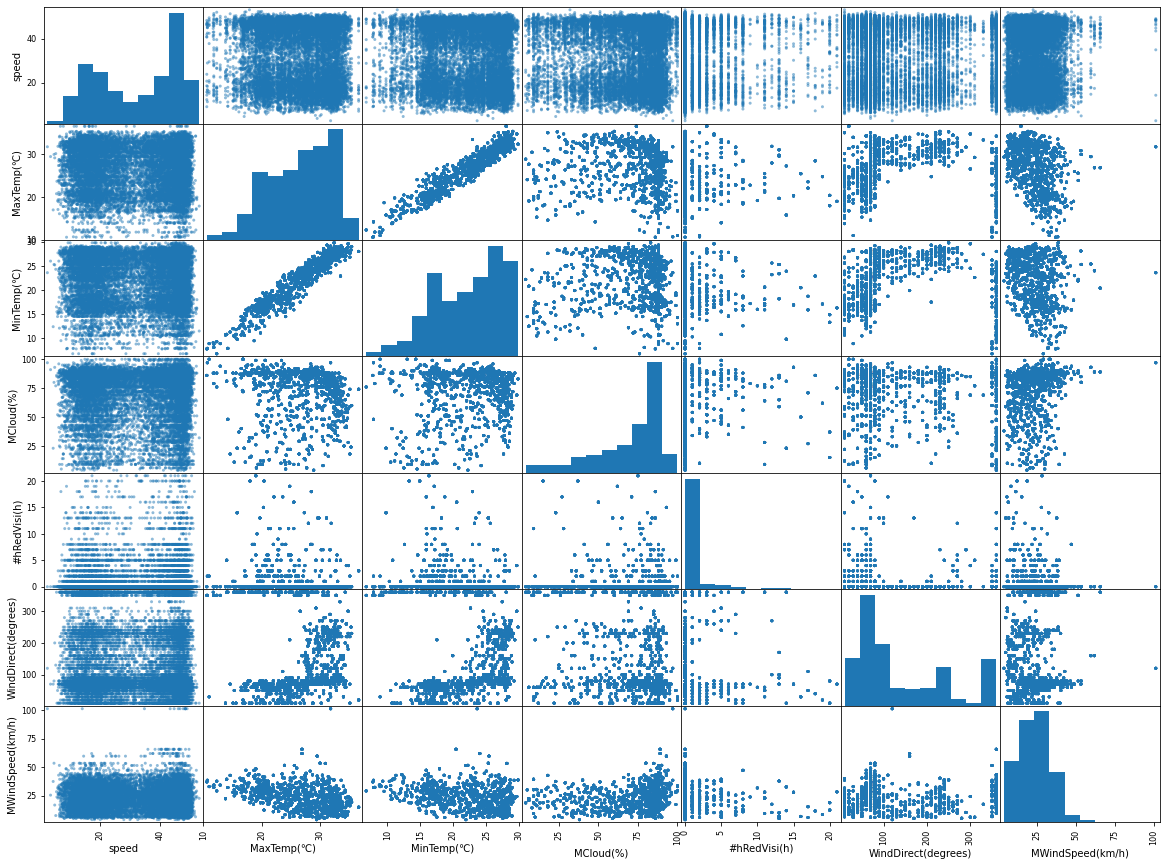

In [27]:
num_vars=['speed','MaxTemp(℃)','MinTemp(℃)','MCloud(%)','#hRedVisi(h)','WindDirect(degrees)','MWindSpeed(km/h)']
from pandas.plotting import scatter_matrix
scatter_matrix(data_taken_for_train[num_vars],figsize=(20,15))
plt.show()

Plotting MaxTemp(℃), MinTemp(℃), MCloud(%), MWindSpeed(km/h) against speed.

<Figure size 720x576 with 0 Axes>

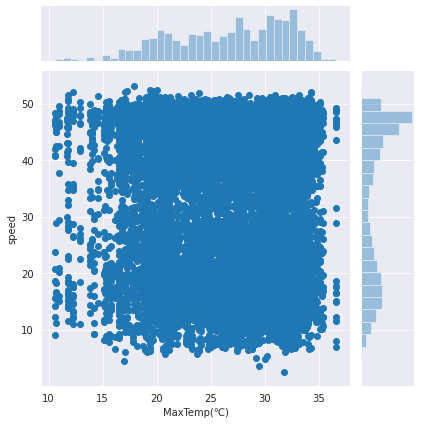

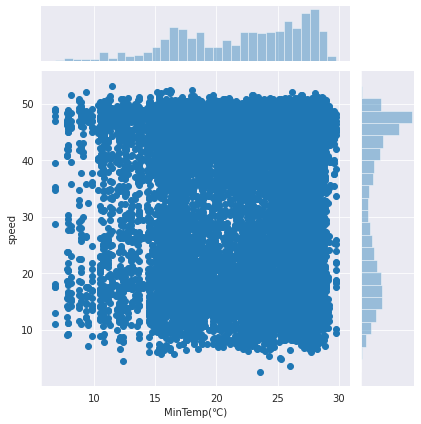

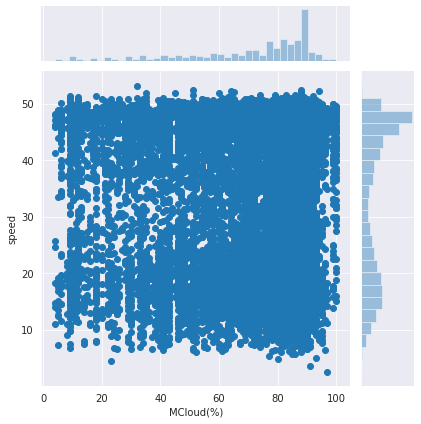

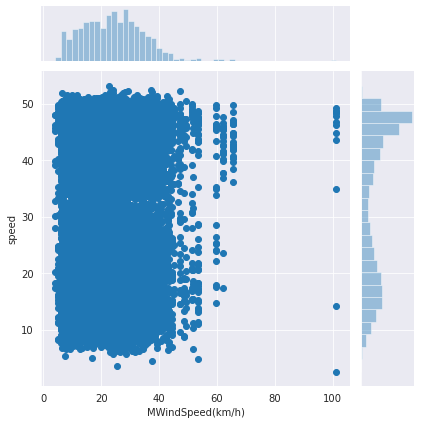

In [28]:
plt.figure(figsize=(10,8))

sns.set_style('darkgrid')
sns.jointplot(y='speed',x='MaxTemp(℃)',data =data_taken_for_train)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='MinTemp(℃)',data =data_taken_for_train)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='MCloud(%)',data =data_taken_for_train)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='MWindSpeed(km/h)',data =data_taken_for_train)

plt.show()

Plotting traffic speed over mean cloud %.

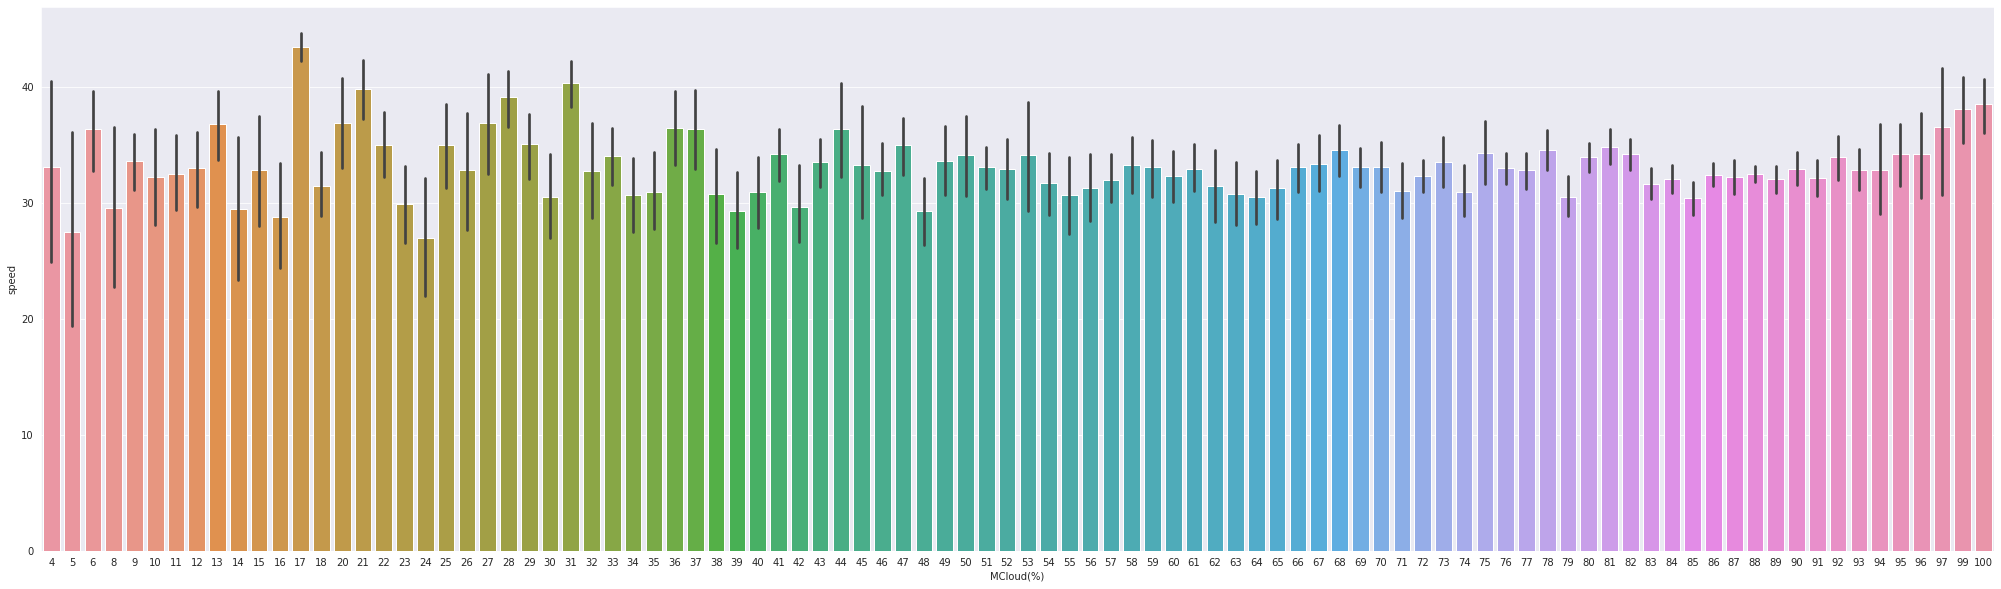

In [29]:
plt.figure(figsize=(35,10))
sns.barplot(x='MCloud(%)', y = 'speed', data = data_taken_for_train)
plt.show()

Analysing the correlation matrix of the numerical variables.

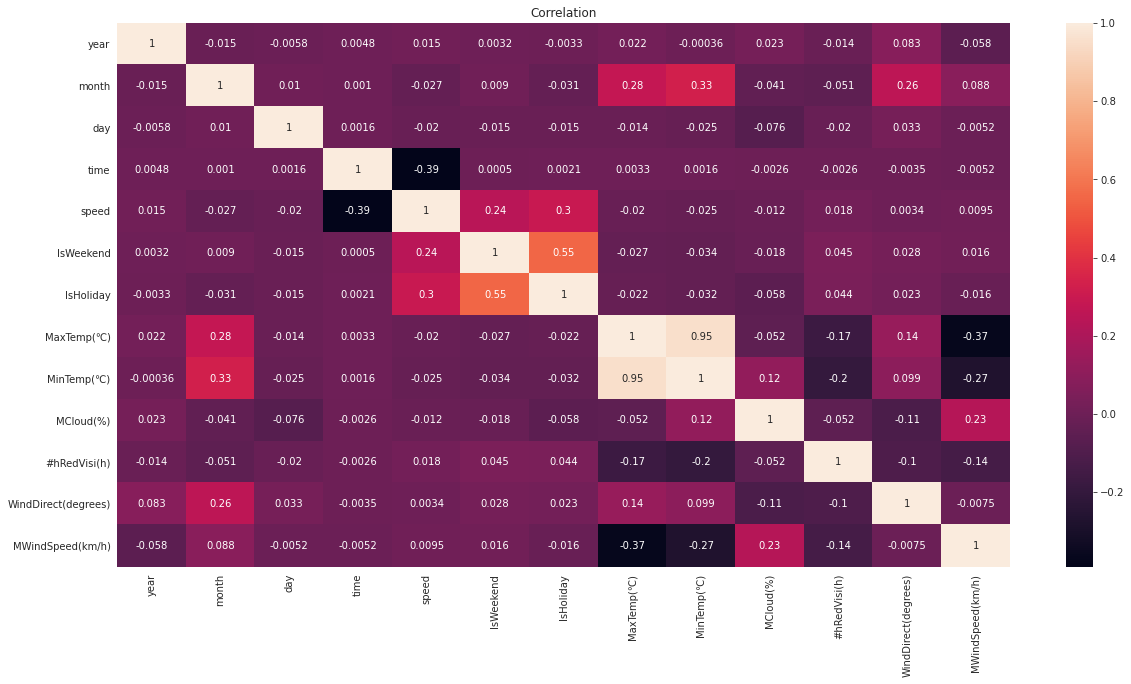

In [30]:
plt.figure(figsize = (20,10))

sns.heatmap(data_taken_for_train.corr(), annot=True)
plt.title('Correlation')
plt.show()

# Prepare the data for machine learning

In [31]:
data_taken_for_train.columns

Index(['year', 'month', 'day', 'time', 'speed', 'IsWeekend', 'IsHoliday',
       'hour_modify', 'MaxTemp(℃)', 'MinTemp(℃)', 'MCloud(%)',
       'TRainfall(mm)_num', '#hRedVisi(h)', 'WindDirect(degrees)',
       'MWindSpeed(km/h)'],
      dtype='object')

In [32]:
target=['speed']
cat_vars=['IsWeekend','IsHoliday','hour_modify']
num_vars=['year','month','day','time','MaxTemp(℃)','MinTemp(℃)','MCloud(%)',
          'TRainfall(mm)_num','#hRedVisi(h)','WindDirect(degrees)',
          'MWindSpeed(km/h)']

In [33]:
# Creating pipeline to transform data
numeric_transformer=Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer=Pipeline(steps=[
    ('oneHot',OneHotEncoder())])

preprocessor=ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

data_transformed=preprocessor.fit_transform(data_taken_for_train)

In [34]:
# Split the data into trainset and testset.

# direction 1
X_train,X_test,y_train,y_test=train_test_split(data_transformed,data_taken_for_train['speed'],test_size=0.15,random_state=42)

# direction 2
# train 2017 to predict 2018
d_2017=data_taken_for_train[data_taken_for_train['year']==2017]
d_2018=data_taken_for_train[data_taken_for_train['year']==2018]
X_2017=preprocessor.fit_transform(d_2017)
X_2018=preprocessor.fit_transform(d_2018)
y_2017=d_2017['speed']
y_2018=d_2018['speed']

In [35]:
print('Shape of X_train: ',str(X_train.shape));print('Shape of y_train: ',str(y_train.shape))
print('Shape of X_test: ',str(X_test.shape));print('Shape of y_test: ',str(y_test.shape))

print('-'*30)

print('Shape of X_2017: ',str(X_2017.shape));print('Shape of y_2017: ',str(y_2017.shape))
print('Shape of X_2018: ',str(X_2018.shape));print('Shape of y_2018: ',str(y_2018.shape))

Shape of X_train:  (11905, 21)
Shape of y_train:  (11905,)
Shape of X_test:  (2101, 21)
Shape of y_test:  (2101,)
------------------------------
Shape of X_2017:  (8750, 21)
Shape of y_2017:  (8750,)
Shape of X_2018:  (5256, 21)
Shape of y_2018:  (5256,)


# Train and fine tune models

Regression task.

In [36]:
# 1. train a XGBoostRegressor
tscv = TimeSeriesSplit(n_splits=3)
model = XGBRegressor()

param_grid = {'nthread':[4,6,8], 
              'objective':['reg:squarederror'],
              'learning_rate':[.03, 0.05, .07],
              'max_depth':[5, 6, 7],
              'min_child_weight':[4],
              'subsample':[0.7],
              'colsample_bytree':[0.7],
              'n_estimators':[500]}

GridSearch=GridSearchCV(estimator=model,param_grid=param_grid,cv=tscv,n_jobs=2)
GridSearch.fit(X_train,y_train)
y_pred=GridSearch.predict(X_test)

In [37]:
# XGBoostRegressor for direction 2
GridSearch_d2=GridSearchCV(estimator=model,param_grid=param_grid,cv=tscv,n_jobs=2)
GridSearch_d2.fit(X_2017,y_2017)
y_pred_2018=GridSearch_d2.predict(X_2018)

In [38]:
# 2. train a RandomForestRegressor
model2=RandomForestRegressor()

param_grid2={'n_estimators':[10,50,100,1000],
             'max_features':[1, 2, 3]   
            }

GridSearch2=GridSearchCV(estimator=model2,param_grid=param_grid2,cv=tscv,n_jobs=2)
GridSearch2.fit(X_train,y_train)
y_pred2=GridSearch2.predict(X_test)

In [39]:
# RandomForestRegressor for direction 2
GridSearch2_d2=GridSearchCV(estimator=model2,param_grid=param_grid2,cv=tscv,n_jobs=2)
GridSearch2_d2.fit(X_2017,y_2017)
y_pred2_2018=GridSearch2_d2.predict(X_2018)

# Model evaluation

In [40]:
MSE_xgb=mean_squared_error(y_pred,y_test)  # 10.7063378519613
MSE_rf=mean_squared_error(y_pred2,y_test)
print('-'*15,'Direction 1','-'*15)
print('MSE for XGBoost is '+str(MSE_xgb))
print('MSE for RandomForest is '+str(MSE_rf))

--------------- Direction 1 ---------------
MSE for XGBoost is 10.7063378519613
MSE for RandomForest is 13.09731661586437


XGBoost performs better than RandomForest in this regression task. We use XGBoost for the following prediction.

In [41]:
MSE_xgb_d2=mean_squared_error(y_pred_2018,y_2018)
MSE_rf_d2=mean_squared_error(y_pred2_2018,y_2018)
print('-'*15,'Direction 2','-'*15)
print('MSE for XGBoost is '+str(MSE_xgb_d2))
print('MSE for RandomForest is '+str(MSE_rf_d2))

--------------- Direction 2 ---------------
MSE for XGBoost is 16.696331445836122
MSE for RandomForest is 16.6117146528273


Performance is not so good in direction 2 as in direction 1. Maybe the proportion of testset is too large in this way and undermined model performace. Therefore, I choose to use XGBoost built in direction 1 to predict test.csv.

# Prediction on test data

In [42]:
# Prepare for prediction
testset=test.copy()
testset.drop('id',axis=1,inplace=True)

testset['year']=testset['date'].apply(lambda y:int(y.split()[0].split('/')[2]))
testset['month']=testset['date'].apply(lambda m:int(m.split()[0].split('/')[1]))
testset['day']=testset['date'].apply(lambda d:int(d.split()[0].split('/')[0]))
testset['time']=testset['date'].apply(lambda t:int(t.split()[1].split(':')[0]))
testset['datetime']=testset['date'].apply(lambda x:
           datetime.datetime(  int(x.split()[0].split('/')[2]),
           int(x.split()[0].split('/')[1]),
           int(x.split()[0].split('/')[0]),
           int(x.split()[1].split(':')[0])  )
           )
testset['IsWeekend']=testset['datetime'].apply(lambda x:0 if x.weekday() in [0,1,2,3,4] else 1)
testset['IsHoliday']=testset['datetime'].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
           '2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04',
           '2017-04-14','2017-04-15','2017-04-17','2017-05-01','2017-05-03',
           '2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28',
           '2017-12-25','2017-12-26',
           '2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-03-30',
           '2018-03-31','2018-04-02','2018-04-05','2018-05-01','2018-05-22',
           '2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17',
           '2018-12-25','2018-12-26'
           ])
           or(x.weekday() in[6]) else 0)

testset['hour_modify']=testset['time'].apply(hour_modify)

testset['common']=testset['datetime'].apply(lambda x:x.date())

testdata=pd.merge(testset[['datetime','year','month','day','time','IsWeekend','IsHoliday','hour_modify','common']],
              weather[['MaxTemp(℃)','MinTemp(℃)','MCloud(%)','TRainfall(mm)_num','#hRedVisi(h)','WindDirect(degrees)','MWindSpeed(km/h)','common']],on='common',how='left')\

testdata.head()

,datetime,year,month,day,time,IsWeekend,IsHoliday,hour_modify,common,MaxTemp(℃),MinTemp(℃),MCloud(%),TRainfall(mm)_num,#hRedVisi(h),WindDirect(degrees),MWindSpeed(km/h)
0,2018-01-01 02:00:00,2018,1,1,2,0,1,Late_Night,2018-01-01,19.0,16.3,75,0,21,70,28.4
1,2018-01-01 05:00:00,2018,1,1,5,0,1,Early_Morning,2018-01-01,19.0,16.3,75,0,21,70,28.4
2,2018-01-01 07:00:00,2018,1,1,7,0,1,Early_Morning,2018-01-01,19.0,16.3,75,0,21,70,28.4
3,2018-01-01 08:00:00,2018,1,1,8,0,1,Morning,2018-01-01,19.0,16.3,75,0,21,70,28.4
4,2018-01-01 10:00:00,2018,1,1,10,0,1,Morning,2018-01-01,19.0,16.3,75,0,21,70,28.4


In [43]:
# Prediction
test_transformed=preprocessor.fit_transform(testdata)
y_test_pred=GridSearch.predict(test_transformed)

In [44]:
print(len(y_test_pred))
test_transformed.shape[0]

3504


3504

In [45]:
# Write into test.casv and save as submission_20710754.csv

pred=pd.DataFrame({'speed':list(y_test_pred)},columns=['speed'])
submission=pd.concat([test.drop('date',axis=1),pred],axis=1)
submission.head()

,id,speed
0,0,48.061958
1,1,47.109604
2,2,38.653557
3,3,32.527283
4,4,39.595612


In [46]:
submission.shape

(3504, 2)

In [47]:
from subprocess import check_output
print(check_output(["ls","../input"]).decode("utf8"))

msbd5001-fall2020
weather



In [48]:
submission.to_csv('submission_20710754.csv',index=False)